### Model testing to check the prediction cpabilities of LSTM for August
#### Model trained on May, April, June, July Uber trip data

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# FIX ME: Root dir as argument
root_dir = "../../data/picklerCheckpoints/"
is_compressed = True;
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import numpy as np
import pandas as pd
import nbimporter
import geopandas as gpd
import commons.utility.pickle_util as pickle
import Preprocessing.SpatialMapping as sm
import Preprocessing.Discretization as dis
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import tensorflow as tf

coord_system = {'init': 'epsg:4326'}

Importing Jupyter notebook from D:\Academics\MLRepoFeb\ML2020-Uber-Data-Analysis\commons\utility\pickle_util.ipynb
Importing Jupyter notebook from D:\Academics\MLRepoFeb\ML2020-Uber-Data-Analysis\Preprocessing\SpatialMapping.ipynb
Importing Jupyter notebook from D:\Academics\MLRepoFeb\ML2020-Uber-Data-Analysis\Preprocessing\DataEnrichment.ipynb
Importing Jupyter notebook from D:\Academics\MLRepoFeb\ML2020-Uber-Data-Analysis\Preprocessing\Discretization.ipynb


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
import keras
from keras import layers

In [5]:
data = sm.run(['aug'])


Data for the month :aug Found.....
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loading file ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-aug14.p
Decompressing ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-aug14.p.pbz2..............Done
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
def ljust(lst, n, fillvalue=0):
    return lst + [fillvalue] * (n - len(lst))

In [8]:
def transposeZones(df2, column):
    dftest = df2[['datetime', column, 'pickups']]
    dftest = dftest.sort_values(['datetime', column], ascending=[True, True]).set_index('datetime')
    #dftest.head(len(dftest.zone.unique())-1)
    zone_order = dftest[column].unique()
    #print(zone_order)
    dftest = dftest.groupby('datetime').agg({lambda x: x.tolist()})
    a = dftest.loc[:, ['pickups']].T
    b = dftest.loc[:, [column]].T
    N = len(zone_order)
    M = np.shape(a)[1]
    acc = []
    idx = 0
    for date in a.columns:
        sub_list_start = 0
        sub_list_end = len(a[date])
        row = a[date].values[0]
        acc.append(ljust(row, N))
       # zeros[idx][sub_list_start : sub_list_end+1] = a[date]
        idx = idx + 1
    #print(acc[0])
    zoneDf = pd.DataFrame(acc, columns=zone_order)
    df3 = df2[['datetime', 'dayOfWeek', 'hourOfDay', 'humidity', 'pressure', 'temperature', 'windDirection', 'holiday', 'windSpeed']].drop_duplicates().reset_index()
    return pd.merge(df3, zoneDf, left_index=True, right_index=True)

In [9]:
df = data.copy()

In [10]:
df2 = df[['datetime', 'zone', 'weatherCondition', 'humidity', 'pressure', 'temperature', 'windDirection', 'windSpeed', 'holiday', 'borough']]

In [11]:
df2 = dis.encode(df2, ['holiday', 'weatherCondition', 'zone'])

D:\Academics\MLRepoFeb\ML2020-Uber-Data-Analysis\Preprocessing\Discretization.ipynb:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "metadata": {},


Result Saved in ../data/encodedMappings/holiday.p
Result Saved in ../data/encodedMappings/weatherCondition.p
Result Saved in ../data/encodedMappings/zone.p


In [12]:
df2['dayOfWeek'] = pd.to_datetime(df2['datetime'], format='%m-%d-%Y:%H')
df2['hourOfDay'] =  pd.to_datetime(df2['datetime'], format='%m-%d-%Y:%H')
df2['dayOfWeek'] = df2['dayOfWeek'].dt.day_name()
df2['hourOfDay'] = df2['hourOfDay'].dt.hour

<ipython-input-12-9ac9e5788ff7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['dayOfWeek'] = pd.to_datetime(df2['datetime'], format='%m-%d-%Y:%H')
<ipython-input-12-9ac9e5788ff7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['hourOfDay'] =  pd.to_datetime(df2['datetime'], format='%m-%d-%Y:%H')
<ipython-input-12-9ac9e5788ff7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [13]:
week_dict = {
    "Sunday": 1,
    "Monday": 2,
    "Tuesday": 3,
    "Wednesday":4,
    "Thursday":5,
    "Friday": 6,
    "Saturday": 7
}

In [14]:
df2['dayOfWeek'] = df2.dayOfWeek.apply(lambda x: week_dict[x])

<ipython-input-14-35d0f5211b87>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['dayOfWeek'] = df2.dayOfWeek.apply(lambda x: week_dict[x])


In [15]:
# data

In [16]:
# cols_to_norm = ['humidity','pressure', 'temperature', 'windDirection', 'windSpeed']
# df2[cols_to_norm] = df2[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [17]:
feature_cols = ['datetime', 'borough', 'dayOfWeek', 'hourOfDay', 'humidity','pressure', 'temperature', 'windDirection', 'holiday', 'windSpeed']
df2 = df2[feature_cols]
N = len(df2['borough'].unique())

In [18]:
actualCounts = df2.borough.value_counts()

In [19]:
df2 = df2.groupby(feature_cols).size().reset_index(name='pickups')
actual = df2.groupby(['borough']).size().reset_index(name='pickups')

In [20]:
# pickups = df2['pickups']
# pickups.pop(0)
# pickups.reset_index(inplace=True, drop=True)
# df2.drop(df2.tail(1).index,inplace=True)


In [21]:
# df2['Pickups_t-1h'] = pickups 
# df2['zone'] = df2['borough']

In [22]:
df2 = transposeZones(df2, 'borough')

In [23]:
dfFeatures = df2[['datetime']]
df2 = df2.drop(['index', 'datetime'], 1)

In [24]:
sampleSize = len(df2.index)

In [25]:
# feature_cols = ['datetime', 'zone', 'dayOfWeek', 'hourOfDay', 'humidity','pressure', 'temperature', 'windDirection', 'windSpeed', 'Pickups_t-1h', 'pickups']
# df2 = df2[feature_cols]

In [26]:
values = df2.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# scaler = pickle.load('../data/picklerCheckpoints/LSTM/Borough300/normScale.p', True)

In [27]:
reframed = series_to_supervised(scaled, 7, N)

In [28]:
listOfDrops = []
for i in range(7*len(df2.columns),len(reframed.columns)):
    listOfDrops.append(i)

# print("list of drops ", listOfDrops)
reframed.drop(reframed.columns[listOfDrops], axis=1, inplace=True)

In [29]:
values = reframed.values

In [30]:
df2

,dayOfWeek,hourOfDay,humidity,pressure,temperature,windDirection,holiday,windSpeed,Bronx,Brooklyn,EWR,Manhattan,Queens,Staten Island
0,6,0,57.0,1019.0,297.51,0.0,0,2.0,7,274,1,1067,86,0
1,6,1,61.0,1020.0,296.48,180.0,0,3.0,2,158,5,652,35,2
2,6,2,69.0,1020.0,295.43,180.0,0,3.0,10,96,1,428,30,0
3,6,3,69.0,1020.0,294.62,190.0,0,3.0,5,131,506,28,0,0
4,6,4,73.0,1021.0,293.91,220.0,0,3.0,9,133,4,570,65,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,1,19,46.0,1016.0,303.45,230.0,1,7.0,27,497,15,1775,256,0
740,1,20,46.0,1015.0,302.18,220.0,1,6.0,45,574,13,1458,267,2
741,1,21,88.0,1016.0,299.70,240.0,1,6.0,22,570,12,1726,317,4
742,1,22,94.0,1015.0,298.71,0.0,1,1.0,37,497,16,1702,274,2


In [31]:
# split into train and test sets
values = reframed.values
n_train_hours = 0
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-N], train[:, -N:]
test_X, test_y = test[:, :-N], test[:, -N:]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(0, 1, 92) (0, 6) (732, 1, 92) (732, 6)


In [32]:
np.shape(values)

(732, 98)

In [33]:
import random
import datetime
random.seed(42)

In [34]:
model = keras.models.load_model('../data/picklerCheckpoints/LSTM/Borough300')

In [35]:
yhat = model.predict(test_X)

(732, 14)


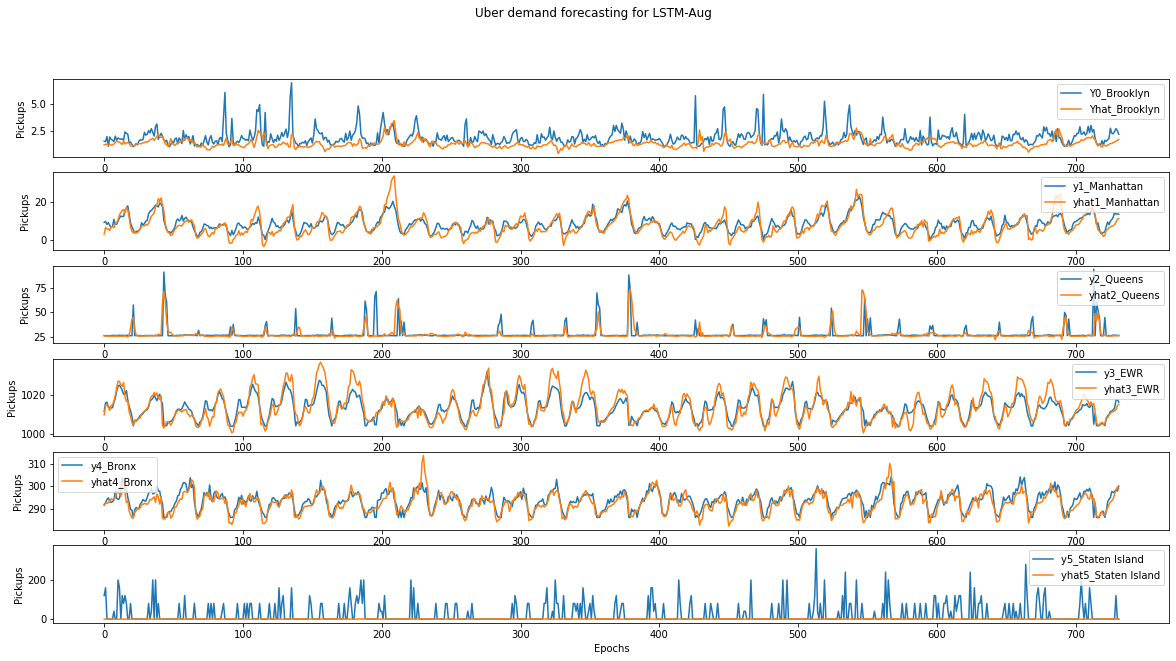

In [36]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 84:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), N))
inv_y = np.concatenate((test_y, test_X[:, 84:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:]
print(inv_y.shape)

f3 = pyplot.figure(figsize=(20,10))
pyplot.subplot(6, 1, 1)
pyplot.plot(inv_y[:,0],label='Y0_Brooklyn')
pyplot.plot(inv_yhat[:,0],label='Yhat_Brooklyn')
pyplot.xlabel("Epochs")
pyplot.ylabel("Pickups")
pyplot.legend()

pyplot.subplot(6, 1, 2)
pyplot.plot(inv_y[:,1],label='y1_Manhattan')
pyplot.plot(inv_yhat[:,1],label='yhat1_Manhattan')
pyplot.xlabel("Epochs")
pyplot.ylabel("Pickups")
pyplot.legend()

pyplot.subplot(6, 1, 3)
pyplot.plot(inv_y[:,2],label='y2_Queens')
pyplot.plot(inv_yhat[:,2],label='yhat2_Queens')
pyplot.xlabel("Epochs")
pyplot.ylabel("Pickups")
pyplot.legend()

pyplot.subplot(6, 1, 4)
pyplot.plot(inv_y[:,3],label='y3_EWR')
pyplot.plot(inv_yhat[:,3],label='yhat3_EWR')
pyplot.xlabel("Epochs")
pyplot.ylabel("Pickups")
pyplot.legend()

pyplot.subplot(6, 1, 5)
pyplot.plot(inv_y[:,4],label='y4_Bronx')
pyplot.plot(inv_yhat[:,4],label='yhat4_Bronx')
pyplot.xlabel("Epochs")
pyplot.ylabel("Pickups")
pyplot.legend()

pyplot.subplot(6, 1, 6)
pyplot.plot(inv_y[:,5],label='y5_Staten Island')
pyplot.plot(inv_yhat[:,5],label='yhat5_Staten Island')
pyplot.xlabel("Epochs")
pyplot.ylabel("Pickups")
pyplot.legend()
f3.suptitle('Uber demand forecasting for LSTM-Aug')

pyplot.show()

In [37]:
# calculate RMSE
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 15.412


In [38]:
# borough_counts

In [39]:
boroughs = ['Bronx', 'Brooklyn', 'EWR', 'Manhattan', 'Queens', 'Staten Island']

In [40]:
# actual = pd.DataFrame(inv_y, columns = df2.columns)

In [41]:
predictions = pd.DataFrame(inv_yhat, columns = df2.columns)

In [42]:
# x = actual[boroughs]
y = predictions[boroughs]

In [43]:
# rmse = math.sqrt(mean_squared_error(x, y))
# print('Test RMSE: %.3f' % rmse)
actual

,borough,pickups
0,Bronx,736
1,Brooklyn,744
2,EWR,684
3,Manhattan,744
4,Queens,744
5,Staten Island,189


In [44]:
predictions

,dayOfWeek,hourOfDay,humidity,pressure,temperature,windDirection,holiday,windSpeed,Bronx,Brooklyn,EWR,Manhattan,Queens,Staten Island
0,1.182654,2.927253,25.963326,1009.782007,291.898831,-0.107459,0.833333,2.347826,106.529412,537.714286,671.091503,2436.666667,0.0,2.0
1,1.226980,6.469588,25.726056,1014.628411,292.504750,-0.120694,0.833333,2.739130,116.676471,537.714286,620.045752,2580.000000,0.0,3.0
2,1.214858,5.589935,25.684880,1014.964098,292.291886,-0.186558,0.833333,3.130435,114.647059,506.142857,605.196078,1820.333333,0.0,1.0
3,1.190489,5.657966,25.745165,1014.081029,292.781253,-0.013477,0.833333,3.521739,116.676471,537.714286,594.986928,2723.333333,0.0,3.0
4,1.212495,4.854155,25.608624,1012.100152,293.098529,-0.022806,0.833333,3.913043,126.823529,569.285714,573.640523,3440.000000,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,1.385513,7.284090,25.998994,1011.442992,294.388491,0.054935,0.000000,5.086957,116.676471,506.142857,896.620915,3296.666667,389.0,4.0
728,1.446677,7.960480,25.984707,1011.849252,296.510162,0.075038,0.000000,5.478261,106.529412,474.571429,982.934641,2866.666667,389.0,3.0
729,1.516951,9.209648,26.013164,1012.491908,298.397579,0.168869,0.000000,5.869565,88.264706,443.000000,1139.784314,3153.333333,389.0,5.0
730,1.598695,10.818392,26.082869,1014.437565,299.820459,0.214367,0.000000,6.260870,82.176471,443.000000,1288.281046,3296.666667,389.0,6.0


In [45]:
Bronx = predictions['Bronx'].sum()
Brooklyn = predictions['Bronx'].sum()
EWR = predictions['EWR'].sum()
Manhattan = predictions['Manhattan'].sum()
Queens = predictions['Queens'].sum()
Staten_Island = predictions['Staten Island'].sum()

In [46]:
borough_counts = [Bronx, Brooklyn, EWR, Manhattan, Queens, Staten_Island]


In [47]:
coord_system = {'init': 'epsg:4326'}

In [48]:
def loadBoroughBoundaries():
    nyCoordinates = gpd.read_file('../data/NewYorkCoords/shapefiles/taxi_zones.shp').to_crs(coord_system)
    nyCoordinates = nyCoordinates.drop(['Shape_Area', 'Shape_Leng', 'OBJECTID'], axis=1)
    return nyCoordinates

In [49]:
coDf = loadBoroughBoundaries()

DriverError: ../data/NewYorkCoords/shapefiles/taxi_zones.shp: No such file or directory

In [ ]:
!{sys.executable} -m pip install descartes
cDf = gpd.read_file(gpd.datasets.get_path('nybb'))

In [ ]:
# cDf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

In [ ]:
bcountdf = pd.DataFrame(borough_counts, columns=['BoroCount'])
bdf = pd.DataFrame(boroughs, columns=['BoroName'])
boroughDf = pd.merge(bdf, bcountdf, left_index=True, right_index=True)

In [ ]:
merged = pd.merge(cDf, boroughDf, on='BoroName')

In [ ]:
plt.rcParams.update({'font.size': 14})

In [ ]:
actual = actualCounts.to_frame()

In [ ]:
actual['BoroName'] = actual.index

In [ ]:
mergedAc = pd.merge(cDf, actual.rename(columns={'borough': 'BoroCount'}), on='BoroName') 

In [ ]:
fig, (ax1, ax2) = pyplot.subplots(ncols=2, sharex=True, sharey=True, figsize=(20,10))
ax1.set_title('Predicted trips for August')
merged.plot(ax=ax1, column=variable, cmap='OrRd',  legend=True, linewidth=0.8, edgecolor='0.8')
ax1.axis('off')

ax2.set_title('Actual trips for August')
mergedAc.plot(ax=ax2, column=variable, cmap='OrRd',  legend=True, linewidth=0.8, edgecolor='0.8')
ax2.axis('off')

pyplot.savefig('LSTM/LSTM_August_predictions.png')